In [1]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

plt.style.use('ggplot')

In [2]:
train_df = pd.read_csv("data/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
X = train_df.drop(["Survived","Cabin", "Ticket", "Name", "PassengerId"], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [4]:
y = train_df["Survived"]

In [5]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [6]:
for col in ["Sex", "Embarked"]:
    print(f"{col}:\t{X[col].unique()}")

Sex:	['male' 'female']
Embarked:	['S' 'C' 'Q' nan]


In [7]:
X["Embarked"] = X["Embarked"].map({"Q":0, "S":1, "C":2})
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,1.0
1,1,female,38.0,1,0,71.2833,2.0
2,3,female,26.0,0,0,7.9250,1.0
3,1,female,35.0,1,0,53.1000,1.0
4,3,male,35.0,0,0,8.0500,1.0


In [8]:
X["Sex"] = X["Sex"].map({"male":0, "female":1})

In [9]:
X.isnull().any()

Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [10]:
X["Age"] = X["Age"].fillna(X["Age"].median())

In [11]:
X["Embarked"] = X["Embarked"].fillna(X["Embarked"].median())

In [12]:
X.isnull().any()

Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1515)

In [14]:
X_train.shape, y_train.shape

((623, 7), (623,))

In [15]:
X_test.shape, y_test.shape

((268, 7), (268,))

In [16]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
y_pred = RFC.predict(X_test)
y_pred_prob = RFC.predict_proba(X_test) 

In [18]:
metrics.accuracy_score(y_test, y_pred)

0.8283582089552238

In [19]:
exp=shap.TreeExplainer(RFC)
sv_test = exp.shap_values(X_test)
sv_test = sv_test[1]
sv_test.shape

(268, 7)

In [20]:
exp.expected_value[1] + sv_test[0].sum(), y_pred_prob[0]

(0.1437018537018546, array([0.85629815, 0.14370185]))

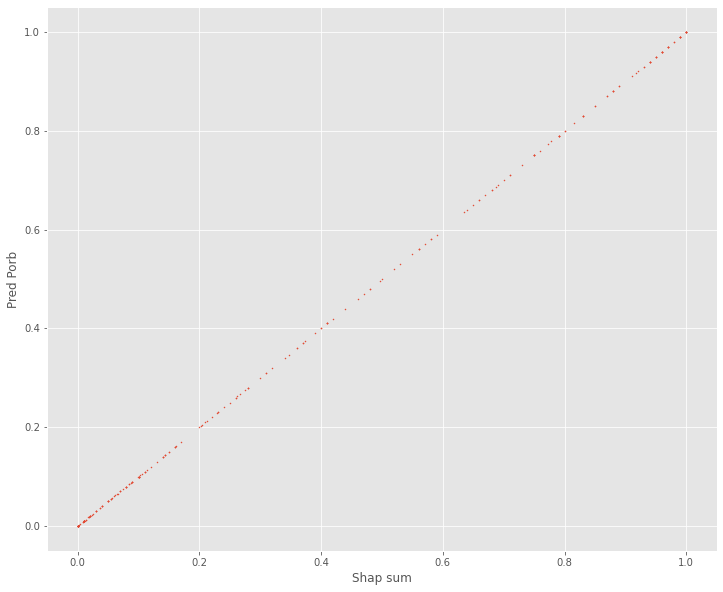

In [29]:
sv_sum = sv_test.sum(axis=1) + exp.expected_value[1]
plt.scatter(sv_sum, y_pred_prob[:,1], s=1)
plt.xlabel("Shap sum")
plt.ylabel("Pred Porb")
plt.savefig("fig/Pred_prob.png")

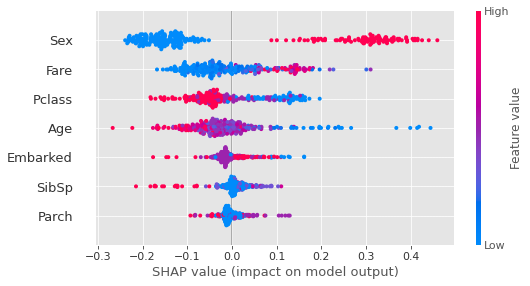

In [31]:
fig = shap.summary_plot(sv_test, X_test, show=False)
plt.savefig("fig/summary_plot.png")

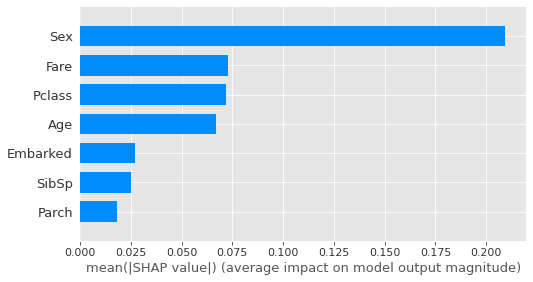

<Figure size 864x720 with 0 Axes>

In [56]:
fig = shap.summary_plot(sv_test, X_test, plot_type="bar", show=False)
plt.savefig("fig/summary_bar.png")

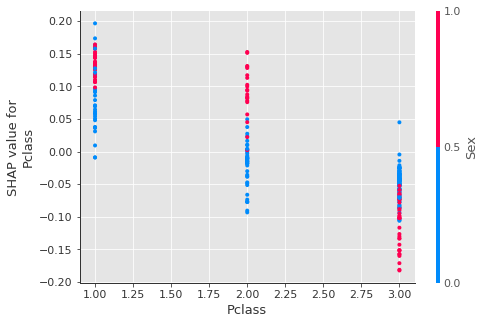

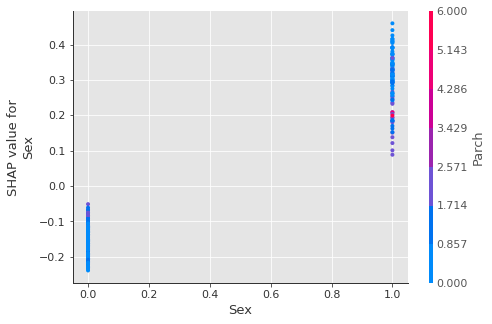

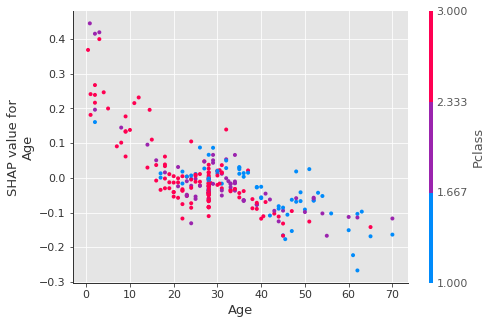

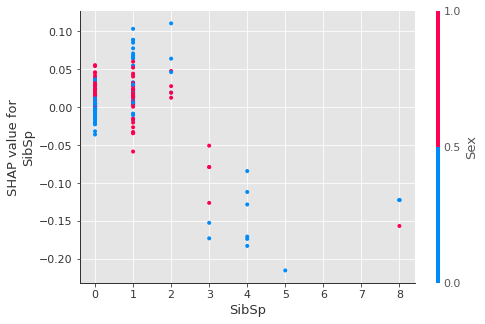

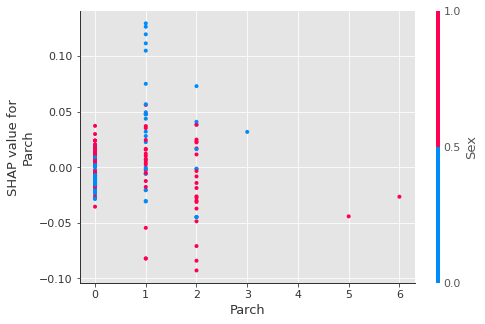

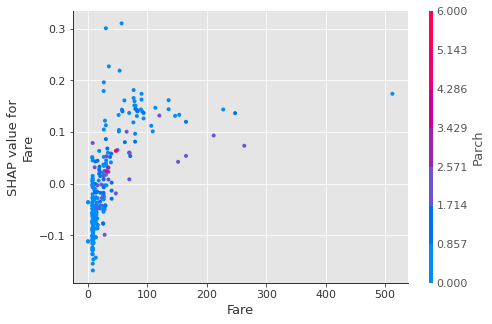

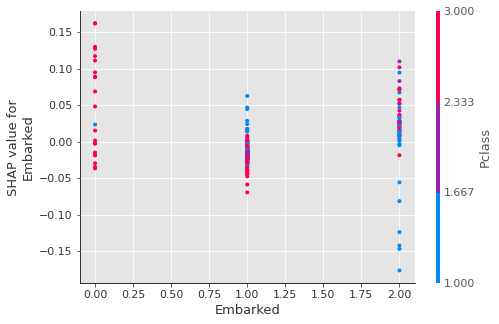

In [55]:
fea_list = X_test.columns

for idx, v in enumerate(fea_list):
    fig = shap.dependence_plot(v, sv_test, X_test, show=False)
    plt.savefig(f"fig/depend_{v}.png")

In [27]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
776,3,0,28.0,0,0,7.7500,0.0
674,2,0,28.0,0,0,0.0000,1.0
243,3,0,22.0,0,0,7.1250,1.0
686,3,0,14.0,4,1,39.6875,1.0
817,2,0,31.0,1,1,37.0042,2.0


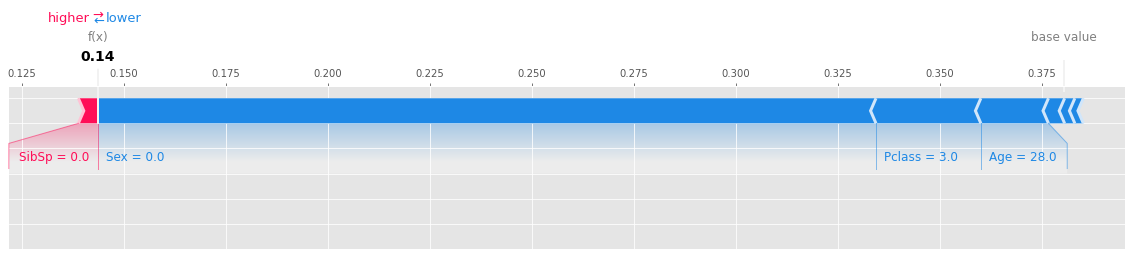

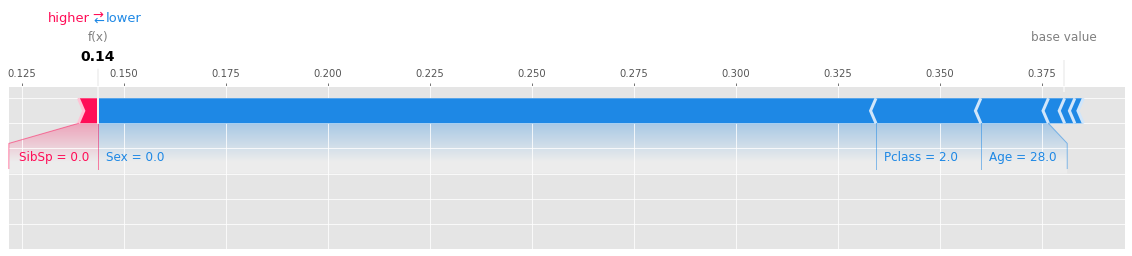

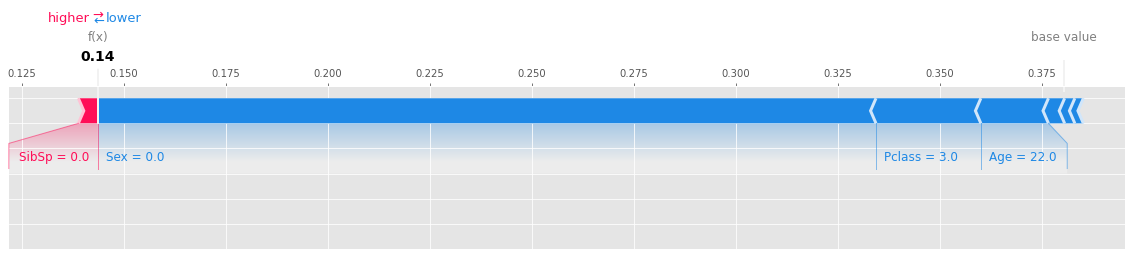

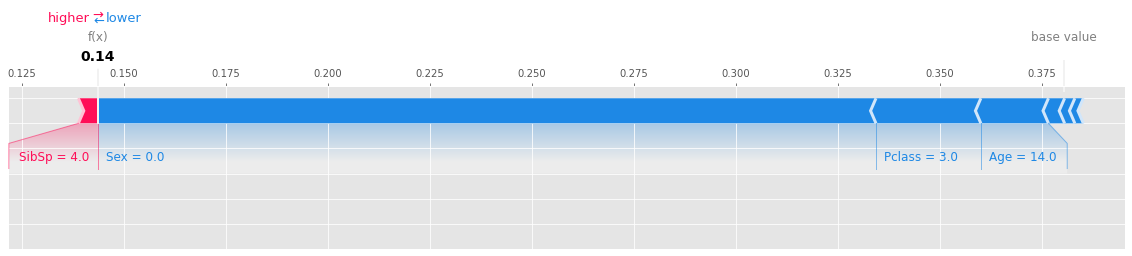

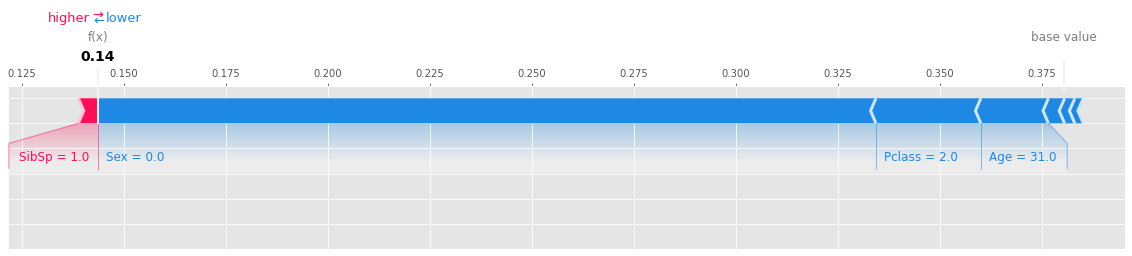

In [28]:
for row in range(0,5):
    shap.force_plot(exp.expected_value[1], sv_test[0], X_test.iloc[row], matplotlib=True)